In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from scipy.stats import bernoulli

%matplotlib inline

In [2]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_size = 64 * 3 * 3

lr = 0.001

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(3, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        self.pool2 = nn.MaxPool2d(3, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.pool3 = nn.AvgPool2d(3, stride=2)
        
        self.fc4 = nn.Linear(64 * 3 * 3, 10)
        
    def forward(self, x):
        activation_1 = F.relu(self.pool1(self.conv1(x)))
        activation_2 = F.relu(self.pool2(self.conv2(activation_1)))
        activation_3 = F.relu(self.pool3(self.conv3(activation_2)))
        activation_3 = activation_3.view(-1, 64 * 3 * 3)
        out = self.fc4(activation_3)
        return out, [torch.sign(activation_1.view(-1, 32 * 15 * 15)), torch.sign(activation_2.view(-1, 32 * 7 * 7)), torch.sign(activation_3)]
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): AvgPool2d (
  )
  (fc4): Linear (576 -> 10)
)


In [4]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        bins = np.arange(0, 1.1, 0.05)
        plt.hist(self.train_activations.mean(0), bins=bins)
        plt.title('Probability of activation')
        plt.show()
        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
if cuda:
    model.cuda()
    criterion.cuda()

In [7]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics_l1 = ActivationFollower()
    metrics_l2 = ActivationFollower()
    metrics_l3 = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics_l1.train_add(activations[0].cpu().data.numpy(), target.cpu().data.numpy())
        metrics_l2.train_add(activations[1].cpu().data.numpy(), target.cpu().data.numpy())
        metrics_l3.train_add(activations[2].cpu().data.numpy(), target.cpu().data.numpy())
        if batch_idx > 500:
            break
        
    print('Layer 1 : ----')
    metrics_l1.print_metrics()
    
    print('Layer 2 : ----')
    metrics_l2.print_metrics()
    
    print('Layer 3 : ----')
    metrics_l3.print_metrics()


Layer 1 : ----


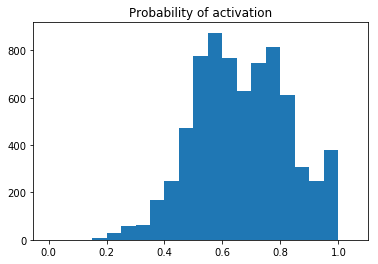

Layer 2 : ----


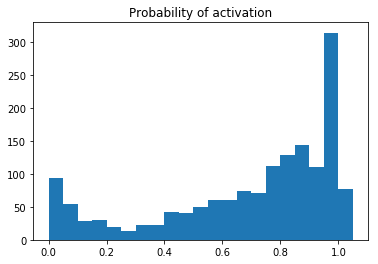

Layer 3 : ----


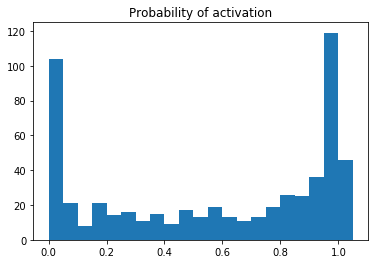

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304423
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.047827
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.763234
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.719282
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.610740
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.552797
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.548937
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.622780

Test set: Average loss: 1.4054, Accuracy: 4801/10000 (48%)

Layer 1 : ----


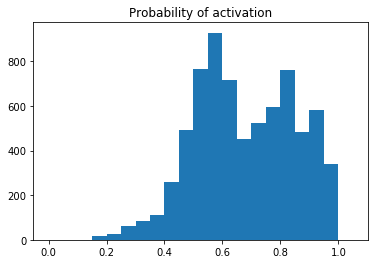

Layer 2 : ----


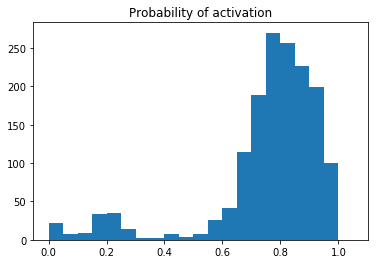

Layer 3 : ----


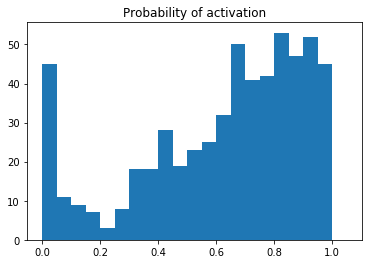

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.781957
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.388563
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.580521
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.749922
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.324402
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.725669
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.726132
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.731936

Test set: Average loss: 1.1779, Accuracy: 5738/10000 (57%)

Layer 1 : ----


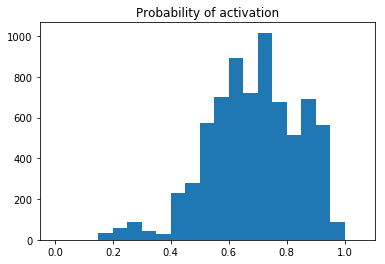

Layer 2 : ----


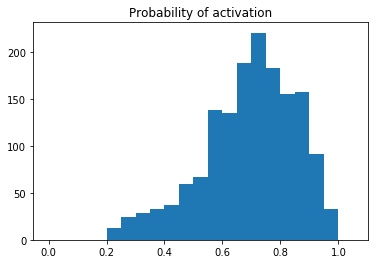

Layer 3 : ----


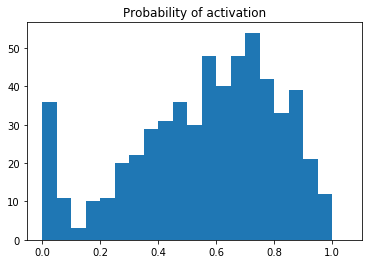

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.190279
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.240355
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.721079
Train Epoch: 3 [19200/50000 (38%)]	Loss: 0.926456
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.060977
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.106391
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.155519
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.141662

Test set: Average loss: 1.0287, Accuracy: 6363/10000 (64%)

Layer 1 : ----


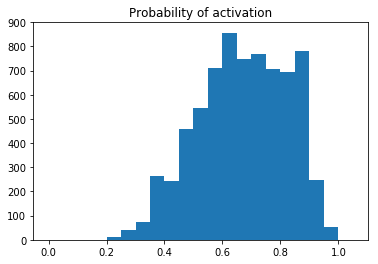

Layer 2 : ----


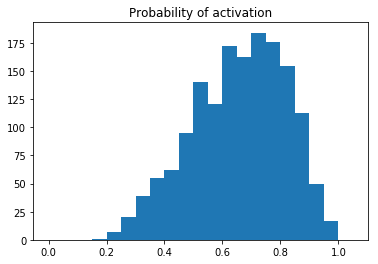

Layer 3 : ----


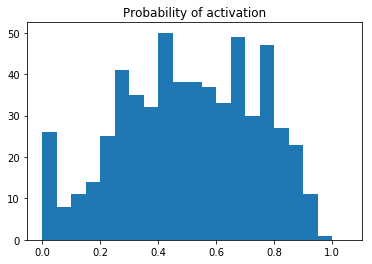

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.102326
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.262801
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.135039
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.320724
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.741038
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.396484
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.803585
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.144043

Test set: Average loss: 0.9496, Accuracy: 6600/10000 (66%)

Layer 1 : ----


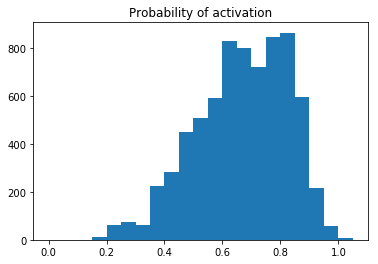

Layer 2 : ----


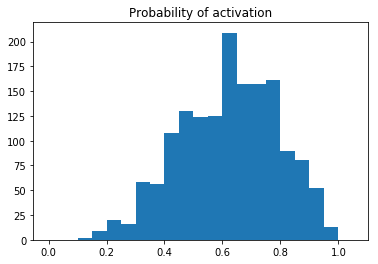

Layer 3 : ----


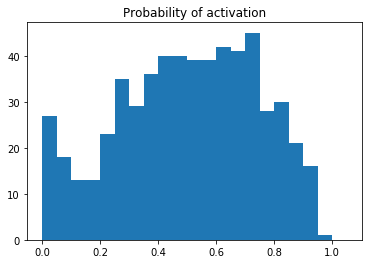

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.415406
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.820020
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.291619
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.513930
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.056918
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.522819
Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.710017
Train Epoch: 5 [44800/50000 (90%)]	Loss: 0.891042

Test set: Average loss: 0.8707, Accuracy: 6917/10000 (69%)

Layer 1 : ----


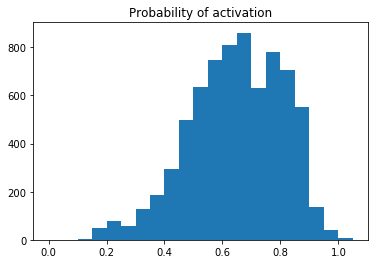

Layer 2 : ----


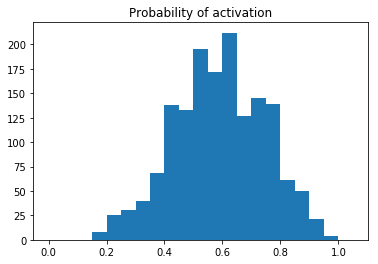

Layer 3 : ----


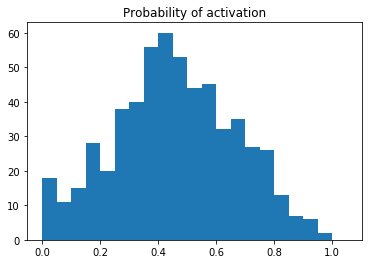

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.293569
Train Epoch: 6 [6400/50000 (13%)]	Loss: 0.581202
Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.851508
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.145019
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.020536
Train Epoch: 6 [32000/50000 (64%)]	Loss: 0.362701
Train Epoch: 6 [38400/50000 (77%)]	Loss: 0.999861
Train Epoch: 6 [44800/50000 (90%)]	Loss: 0.649764

Test set: Average loss: 0.8450, Accuracy: 7076/10000 (71%)

Layer 1 : ----


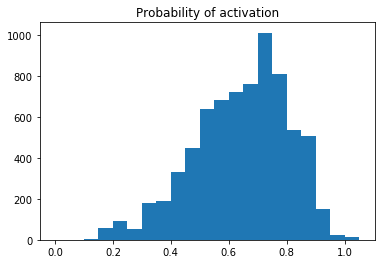

Layer 2 : ----


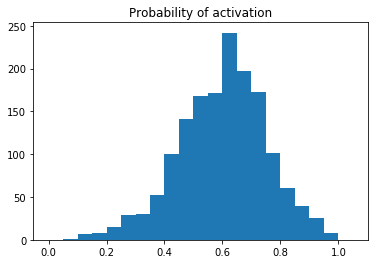

Layer 3 : ----


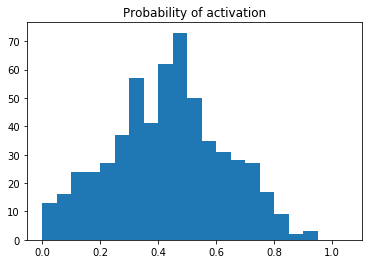

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.555681
Train Epoch: 7 [6400/50000 (13%)]	Loss: 0.856225
Train Epoch: 7 [12800/50000 (26%)]	Loss: 0.923450
Train Epoch: 7 [19200/50000 (38%)]	Loss: 0.490741
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.140325
Train Epoch: 7 [32000/50000 (64%)]	Loss: 0.868159
Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.322978
Train Epoch: 7 [44800/50000 (90%)]	Loss: 0.636244

Test set: Average loss: 0.7972, Accuracy: 7215/10000 (72%)

Layer 1 : ----


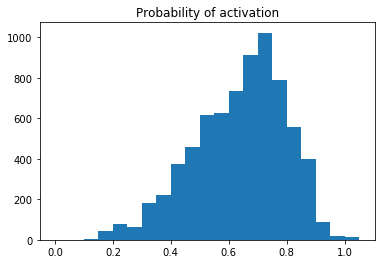

Layer 2 : ----


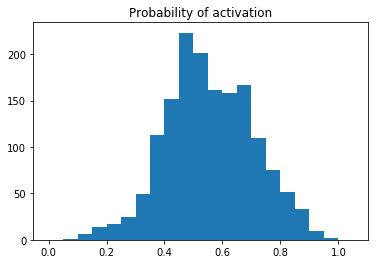

Layer 3 : ----


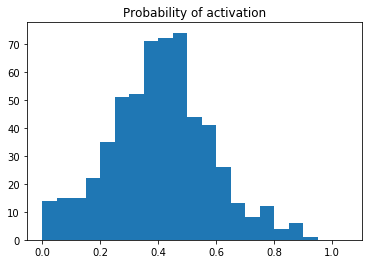

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.680780
Train Epoch: 8 [6400/50000 (13%)]	Loss: 0.678941
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.316877
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.842582
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.308223
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.697846
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.913841
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.897011

Test set: Average loss: 0.8156, Accuracy: 7161/10000 (72%)

Layer 1 : ----


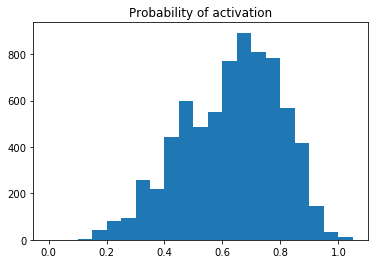

Layer 2 : ----


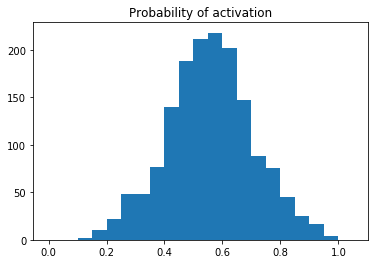

Layer 3 : ----


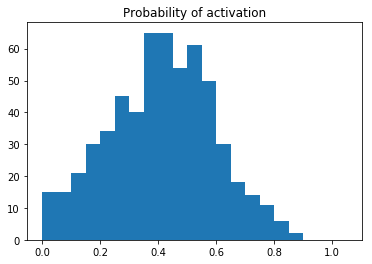

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.691351
Train Epoch: 9 [6400/50000 (13%)]	Loss: 0.718731
Train Epoch: 9 [12800/50000 (26%)]	Loss: 0.460306
Train Epoch: 9 [19200/50000 (38%)]	Loss: 0.730511
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.767902
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.728439
Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.167616
Train Epoch: 9 [44800/50000 (90%)]	Loss: 0.933910

Test set: Average loss: 0.8073, Accuracy: 7247/10000 (72%)

Layer 1 : ----


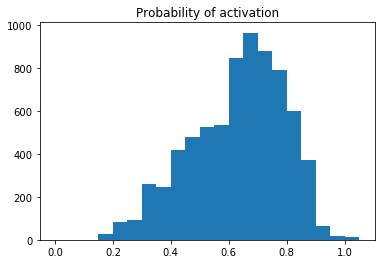

Layer 2 : ----


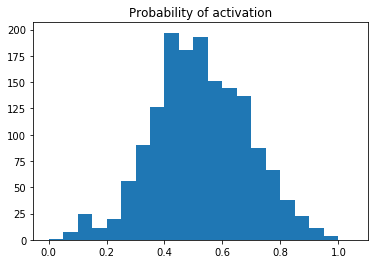

Layer 3 : ----


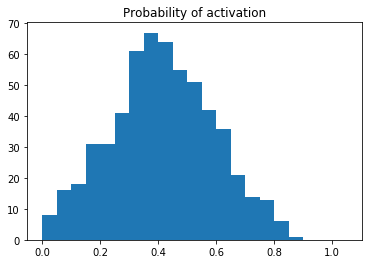

Train Epoch: 10 [0/50000 (0%)]	Loss: 1.077984
Train Epoch: 10 [6400/50000 (13%)]	Loss: 0.383925
Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.425306
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.348163
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.636621
Train Epoch: 10 [32000/50000 (64%)]	Loss: 0.508208
Train Epoch: 10 [38400/50000 (77%)]	Loss: 0.776830
Train Epoch: 10 [44800/50000 (90%)]	Loss: 0.491112

Test set: Average loss: 0.7806, Accuracy: 7342/10000 (73%)

Layer 1 : ----


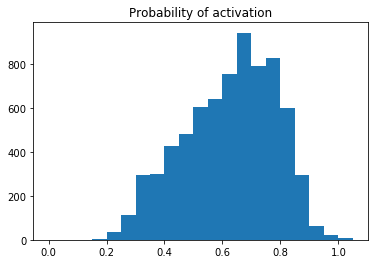

Layer 2 : ----


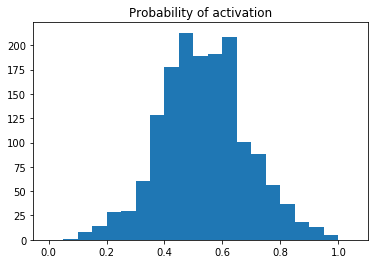

Layer 3 : ----


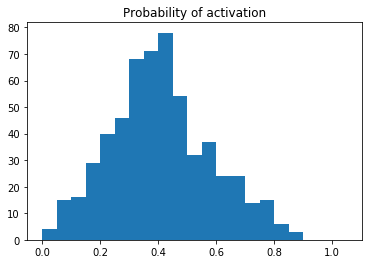

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.225991
Train Epoch: 11 [6400/50000 (13%)]	Loss: 0.345162
Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.014157
Train Epoch: 11 [19200/50000 (38%)]	Loss: 0.422521
Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.453995
Train Epoch: 11 [32000/50000 (64%)]	Loss: 0.509597
Train Epoch: 11 [38400/50000 (77%)]	Loss: 0.620089
Train Epoch: 11 [44800/50000 (90%)]	Loss: 0.394171

Test set: Average loss: 0.7301, Accuracy: 7545/10000 (75%)

Layer 1 : ----


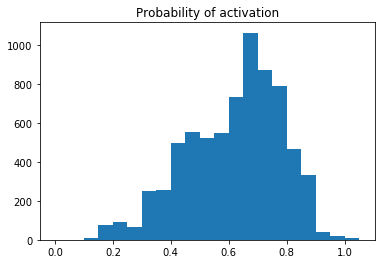

Layer 2 : ----


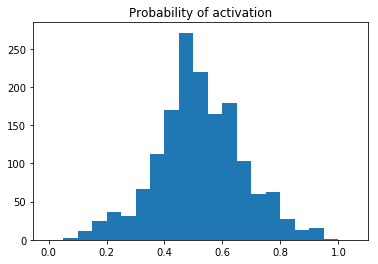

Layer 3 : ----


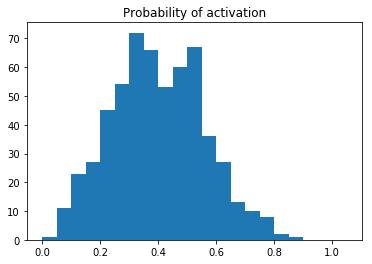

Train Epoch: 12 [0/50000 (0%)]	Loss: 0.536718
Train Epoch: 12 [6400/50000 (13%)]	Loss: 0.717414
Train Epoch: 12 [12800/50000 (26%)]	Loss: 0.511660
Train Epoch: 12 [19200/50000 (38%)]	Loss: 0.865146
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.517660
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.592002
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.571619
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.470698

Test set: Average loss: 0.7695, Accuracy: 7370/10000 (74%)

Layer 1 : ----


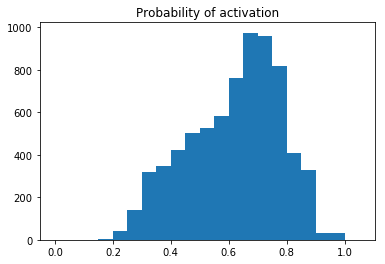

Layer 2 : ----


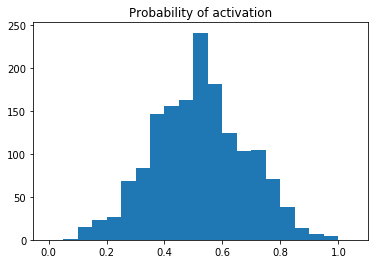

Layer 3 : ----


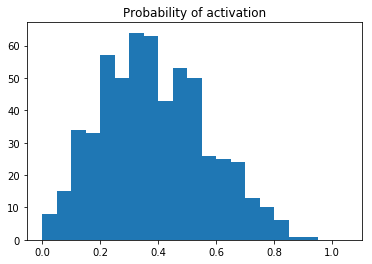

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.302540
Train Epoch: 13 [6400/50000 (13%)]	Loss: 0.621709
Train Epoch: 13 [12800/50000 (26%)]	Loss: 0.785924
Train Epoch: 13 [19200/50000 (38%)]	Loss: 0.430400
Train Epoch: 13 [25600/50000 (51%)]	Loss: 0.366758
Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.267996
Train Epoch: 13 [38400/50000 (77%)]	Loss: 0.717376
Train Epoch: 13 [44800/50000 (90%)]	Loss: 0.454909

Test set: Average loss: 0.7088, Accuracy: 7606/10000 (76%)

Layer 1 : ----


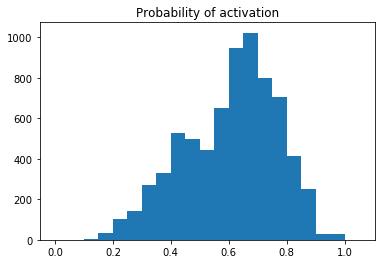

Layer 2 : ----


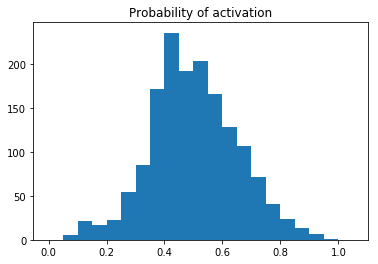

Layer 3 : ----


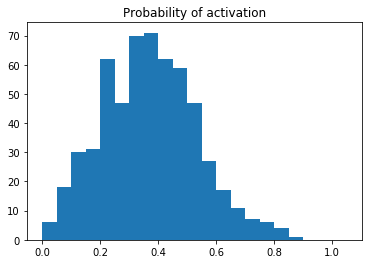

Train Epoch: 14 [0/50000 (0%)]	Loss: 0.458631
Train Epoch: 14 [6400/50000 (13%)]	Loss: 0.562575
Train Epoch: 14 [12800/50000 (26%)]	Loss: 0.280320
Train Epoch: 14 [19200/50000 (38%)]	Loss: 0.259881
Train Epoch: 14 [25600/50000 (51%)]	Loss: 0.590259
Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.445734
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.760433
Train Epoch: 14 [44800/50000 (90%)]	Loss: 1.433417

Test set: Average loss: 0.7346, Accuracy: 7460/10000 (75%)

Layer 1 : ----


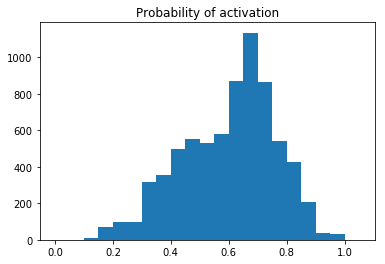

Layer 2 : ----


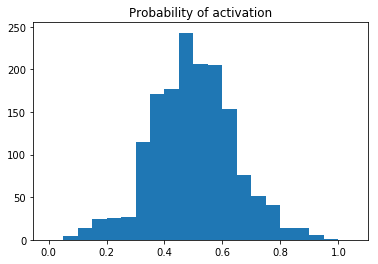

Layer 3 : ----


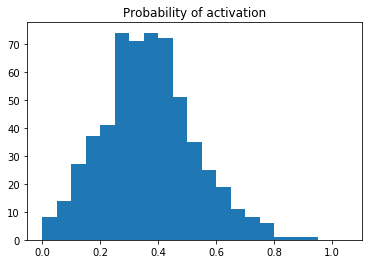

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.396230
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.283020
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.741144
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.208632
Train Epoch: 15 [25600/50000 (51%)]	Loss: 1.006561
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.839443
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.718303
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.636564

Test set: Average loss: 0.7341, Accuracy: 7527/10000 (75%)

Layer 1 : ----


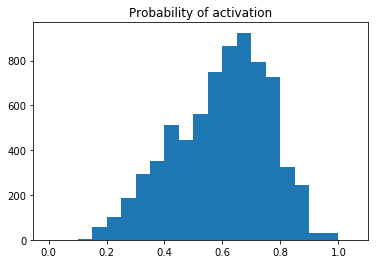

Layer 2 : ----


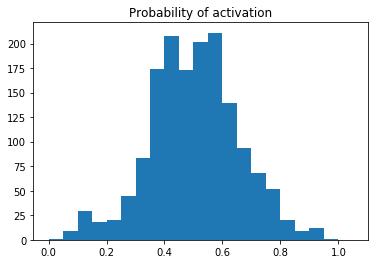

Layer 3 : ----


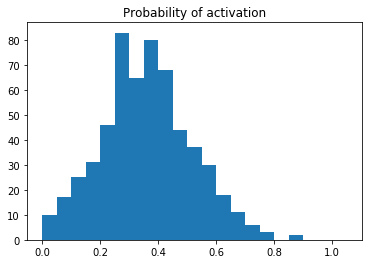

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.075034
Train Epoch: 16 [6400/50000 (13%)]	Loss: 0.390031
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.505066
Train Epoch: 16 [19200/50000 (38%)]	Loss: 1.165486
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.416939
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.536143
Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.856327
Train Epoch: 16 [44800/50000 (90%)]	Loss: 0.449219

Test set: Average loss: 0.7477, Accuracy: 7506/10000 (75%)

Layer 1 : ----


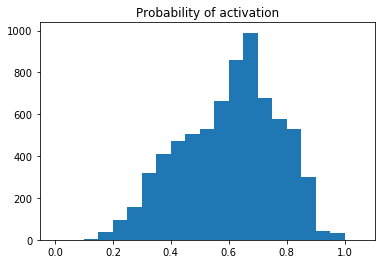

Layer 2 : ----


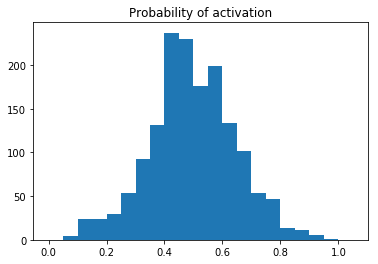

Layer 3 : ----


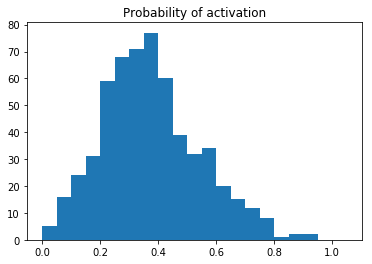

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.503543
Train Epoch: 17 [6400/50000 (13%)]	Loss: 0.577667
Train Epoch: 17 [12800/50000 (26%)]	Loss: 0.747728
Train Epoch: 17 [19200/50000 (38%)]	Loss: 0.854767
Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.702876
Train Epoch: 17 [32000/50000 (64%)]	Loss: 0.356197
Train Epoch: 17 [38400/50000 (77%)]	Loss: 0.698808
Train Epoch: 17 [44800/50000 (90%)]	Loss: 0.956496

Test set: Average loss: 0.7536, Accuracy: 7502/10000 (75%)



Process Process-103:
Process Process-104:
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    self._target(*self._args, **self._kwargs)
    r = index_queue.get()
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/home/lucas

KeyboardInterrupt: 

In [8]:
# activation_metrics()

for epoch in range(1, epochs + 1):
    activation_metrics()
    train(epoch)
    test(epoch)